# Lab1 — Part 2: Training on MNIST

**Course**: Deep Learning for Image Analysis

**Class**: M2 IASD App  

**Professor**: Mehyar MLAWEH

---

In this part, we move from a **toy dataset** to a **real image dataset**.  
We will train a neural network on **MNIST**, **without using CNNs**.

The goal is to understand **why CNNs are needed**, not to use them yet.


## Learning objectives

After this part, you should understand:
- How images are represented as **vectors**
- How a neural network processes image data
- How multi-class classification works
- Why fully-connected networks are **not optimal** for vision tasks


## 0) Environment setup

Make sure you are using **GPU**:
- Runtime → Change runtime type → GPU


In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## 1) Imports


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms


## 2) The MNIST dataset

MNIST contains **handwritten digit images**:
- Image size: **28 × 28**
- Number of channels: **1 (grayscale)**
- Number of classes: **10** (digits 0–9)

Each image is originally a **2D grid of pixels**, but a fully-connected network
expects a **vector** as input.

https://www.youtube.com/watch?v=SrT6QkQUH4Q

### 🔍 Question (conceptual)

- How many pixels does one MNIST image contain?
- What will be the size of the input vector after flattening?




*   Une image MNIST est de taille 28*28 donc elle contient 784 pixels.
*   La taille du vecteur d'entrée sera donc de 784.
(L'opération d'aplatissement transforme simplement la grille 2D de $28 \times 28$ en une seule liste linéaire de toutes les valeurs de pixels).



In [4]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

len(train_dataset), len(test_dataset)


(60000, 10000)

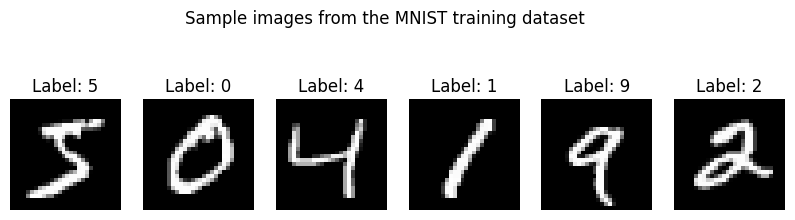

In [5]:

num_images = 6

plt.figure(figsize=(10, 3))

for i in range(num_images):
    image, label = train_dataset[i]

    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.suptitle("Sample images from the MNIST training dataset")
plt.show()


## 3) DataLoader and mini-batches

We use **mini-batches** to train efficiently.

⚠️ Choosing the batch size is a trade-off between speed and memory.


In [6]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 4) Model: Fully-connected neural network (MLP)

### Two experiments with the same model

In this part, we train **the same neural network (MLP)** on two versions of MNIST:

1. **Original MNIST** (centered digits)
2. **Transformed MNIST** (shifted and rotated digits)

#### Experiment 1: MNIST (baseline)

1. **Flatten** the image `(1, 28, 28)` → `(784,)`
2. Feed it to a standard MLP

Architecture:
- Input: 784
- Hidden layer: 256 neurons + ReLU
- Output: 10 neurons (one per class)

The output represents **class scores (logits)**.



In [7]:
class MLP_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

model = MLP_MNIST().to(device)
model


MLP_MNIST(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

### ✅ TODO — Understanding the model

1. How many parameters does this model have?
2. Which layer contains most of the parameters?
Explain briefly.




1.   $$\text{parameters} = (28 \times 28 \times 256) + 256 + (256 \times 10) +10 = 203 530$$
2.   C'est ka premiere couche. Elle doit connecter chaque pixel de l'image (784 entrées) à chacun des 256 neurones de la couche suivante. Ca crée une matrice de poids dense de taille $784 \times 256$. Tandis que la couche de sortie ne connecte que 256 neurones à 10 classes, ce qui demande beaucoup moins de connexions



 **Loss function and optimizer**

This is a **multi-class classification** problem.

- We use `CrossEntropyLoss`
- It combines **Softmax + Negative Log-Likelihood**


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



**Training loop**

The training logic is **exactly the same** as before.
Only the data and the model changed.


In [10]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


Epoch 1/5 - Loss: 0.0783
Epoch 2/5 - Loss: 0.0597
Epoch 3/5 - Loss: 0.0484
Epoch 4/5 - Loss: 0.0386
Epoch 5/5 - Loss: 0.0319


**Evaluation on the test set**

We compute the **classification accuracy**.


In [11]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
accuracy


0.9788

#### Experiment 2: Shifted and rotated MNIST

We now apply random shifts and rotations to the training images.

This breaks the assumption that digits are always centered and aligned.

The **model architecture remains exactly the same**.


In [17]:
transform_augmented = transforms.Compose([
    transforms.RandomAffine(
        degrees=50,
        translate=(0.2, 0.2)
    ),
    transforms.ToTensor()
])

train_dataset_aug = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform_augmented
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform_augmented
)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

len(train_dataset_aug), len(test_dataset)


(60000, 10000)

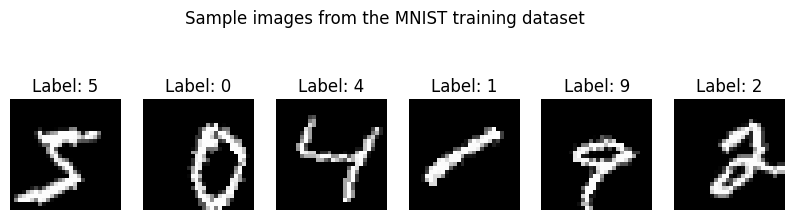

In [18]:

num_images = 6

plt.figure(figsize=(10, 3))

for i in range(num_images):
    image, label = train_dataset_aug[i]

    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.suptitle("Sample images from the MNIST training dataset")
plt.show()


Train the **same model** using the augmented training dataset.

Compare:
- Training loss
- Test accuracy

with the results obtained using original MNIST.


In [22]:
epochs = 5
model_aug= MLP_MNIST().to(device)
for epoch in range(epochs):
    model_aug.train()
    running_loss = 0.0

    for images, labels in train_loader_aug:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_aug)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

Epoch 1/5 - Loss: 0.3424
Epoch 2/5 - Loss: 0.3376
Epoch 3/5 - Loss: 0.3309
Epoch 4/5 - Loss: 0.3250
Epoch 5/5 - Loss: 0.3224


In [24]:
model_aug.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_aug(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f"Test Accuracy (après entraînement sur données augmentées) : {accuracy:.2f}%")


Test Accuracy (après entraînement sur données augmentées) : 9.41%


## 5) What do we observe? (Reflection)

 - Why does the same fully-connected model perform worse on shifted and rotated MNIST images compared to vanilla MNIST?

 - What limitation of fully-connected networks does this experiment reveal when dealing with images?

- Based on these results, what properties should a better model for image data have?

✍️ Write short answers (2–3 lines).




*   Comme le MLP considère chaque pixel comme une entrée indépendante, une simple translation modifie totalement le vecteur d'entrée. Le modèle ne "voit" plus le même objet car il ne reconnaît pas la forme, mais seulement sa position exacte.
*  Les réseaux denses (Fully Connected) ignorent la géométrie 2D de l'image. Ils traitent l'image comme une simple liste de nombres sans lien spatial, ce qui les rend incapables de généraliser une forme à une nouvelle position.


*   Le modèle idéal doit conserver la topologie de l'image (structure de grille) et posséder une invariance par augmentation, c'est-à-dire reconnaître un motif même s'il est décalé ou orienté différemment.





## 6) Looking ahead — why CNNs?

In the next assignment, we will replace this MLP with **Convolutional Neural Networks**.

CNNs:
- Exploit **spatial structure**
- Share parameters
- Achieve **much higher accuracy** on image tasks

👉 You should expect a **significant accuracy improvement** in the next assignment.
